# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


def get_calibration_parameters():
    """
    get parameters for camera calibration from chessboard images
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return objpoints, imgpoints    


## Apply a distortion correction to raw images

In [2]:
def get_undistorted_image(image, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image.shape[0:2], None, None)
    return cv2.undistort(image, mtx, dist)

In [3]:
def show_processed_images(original, processed):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    f.tight_layout()
    ax1.imshow(original)
    ax1.set_title('Original Image', fontsize=15)
    ax2.imshow(processed, cmap='gray')
    ax2.set_title('Processed Image', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

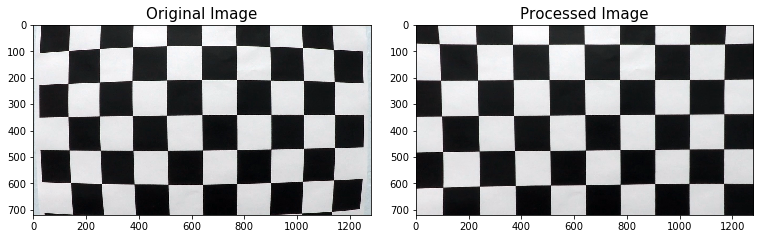

In [4]:
image = cv2.imread("camera_cal/calibration1.jpg")
objpoints, imgpoints = get_calibration_parameters()
undistorted = get_undistorted_image(image, objpoints, imgpoints)
show_processed_images(image, undistorted)

## Create a thresholded binary image

In [5]:
def get_color_threshold_binary_image(image, thresh=(90, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


def get_absolute_sobel_threshold_binary_image(image, orient='x', thresh=(20, 100)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

    
def get_magnitude_threshold_binary_image(image, sobel_kernel=3, thresh=(30, 100)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))

    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output


def get_dicrection_threshold_binary_image(image, sobel_kernel=15, thresh=(0.7, 1.3)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    gradmag = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return binary_output

In [6]:
def get_binary_image(image):
    """
    Create thresholded binary image using color and gradient
    """
    color_th_binary = get_color_threshold_binary_image(image, thresh=(150, 250))
    mag_th_binary = get_magnitude_threshold_binary_image(image, sobel_kernel=7, thresh=(50, 250))
    abs_sobel_th_binary = get_absolute_sobel_threshold_binary_image(image, thresh=(30, 100))
    #dic_th_binary = get_dicrection_threshold_binary_image(image)

    binary_image = np.zeros_like(color_th_binary)
    #binary_image[(color_th_binary == 1) | (mag_th_binary == 1) | (dic_th_binary == 1)] = 1
    binary_image[(color_th_binary == 1) | (mag_th_binary == 1) | (abs_sobel_th_binary == 1)] = 1

    return binary_image

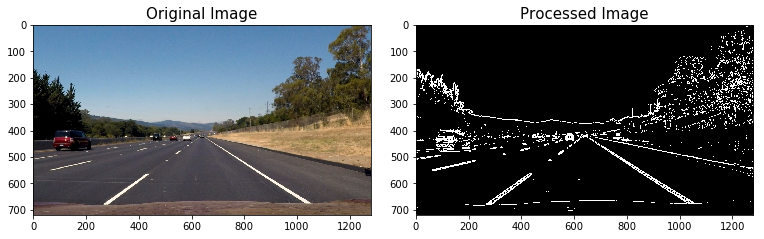

In [7]:
image = mpimg.imread('test_images/straight_lines2.jpg')
processed = get_binary_image(image)
show_processed_images(image, processed)
#plt.savefig("result_straight_lines2.png")

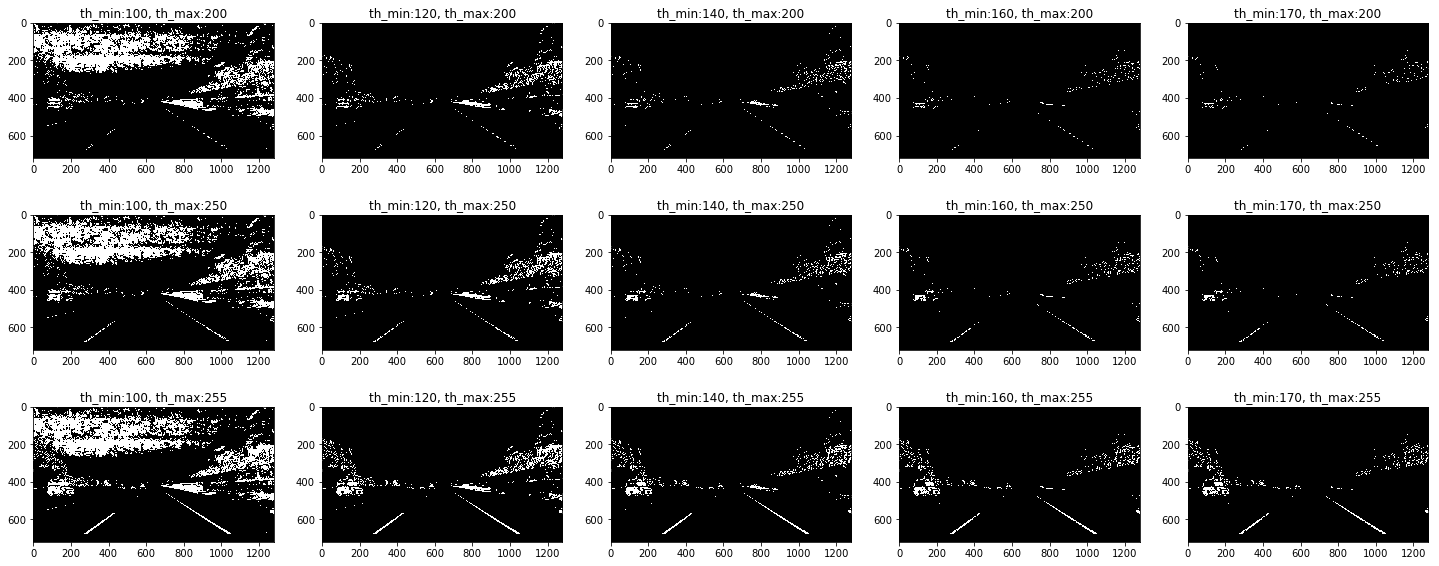

In [8]:
#  visualize result of get_color_threshold_binary_image using some parameter
max_ths = [200, 250, 255]
min_ths = [100, 120, 140, 160, 170]

i = 0
plt.figure(figsize=(25,10))
for max_th  in max_ths:
    for min_th in min_ths:
        plt.subplot(3, 5, i+1)
        train_image = get_color_threshold_binary_image(image, thresh=(min_th, max_th))
        plt.imshow(train_image, cmap='gray')
        title = "th_min:{}, th_max:{}".format(min_th, max_th)
        plt.title(title)
        i += 1

#plt.savefig("color_some_params_2.png")

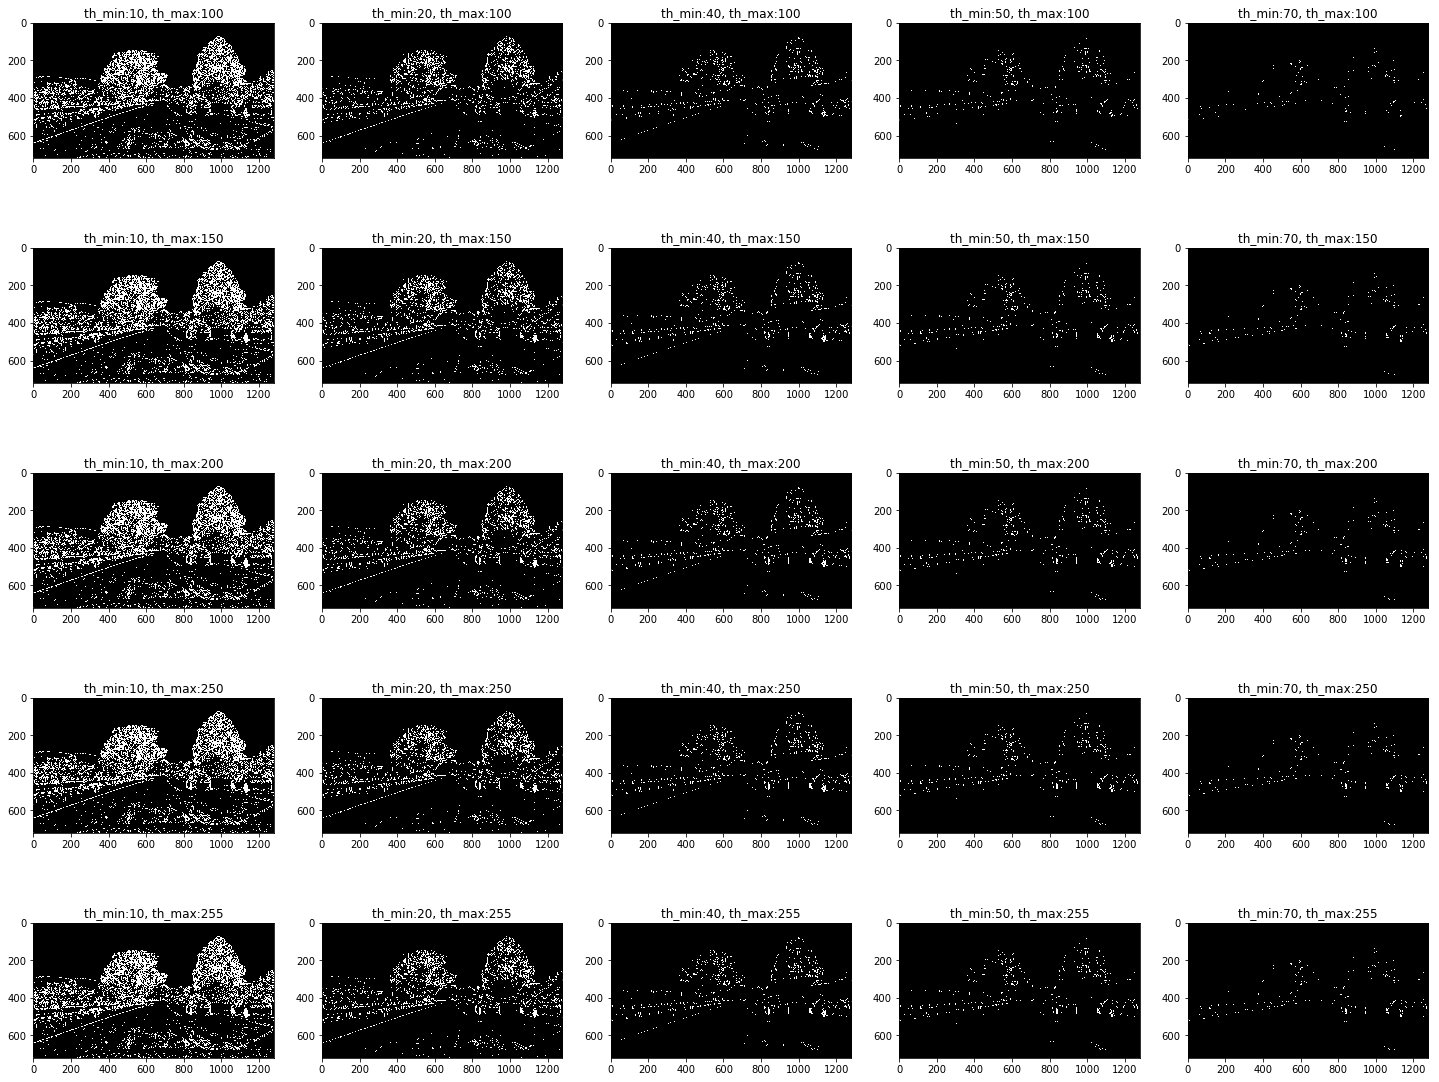

In [9]:
#  visualize result of get_absolute_sobel_threshold_binary_image using some parameter
image = mpimg.imread('test_images/test1.jpg')

max_ths = [100, 150, 200, 250, 255]
min_ths = [10, 20, 40, 50, 70]

i = 0
plt.figure(figsize=(25,20))
for max_th  in max_ths:
    for min_th in min_ths:
        plt.subplot(5, 5, i+1)
        train_image = get_absolute_sobel_threshold_binary_image(image, thresh=(min_th, max_th))
        plt.imshow(train_image, cmap='gray')
        title = "th_min:{}, th_max:{}".format(min_th, max_th)
        plt.title(title)
        i += 1

#plt.savefig("abs_sobel_some_params_test1.png")

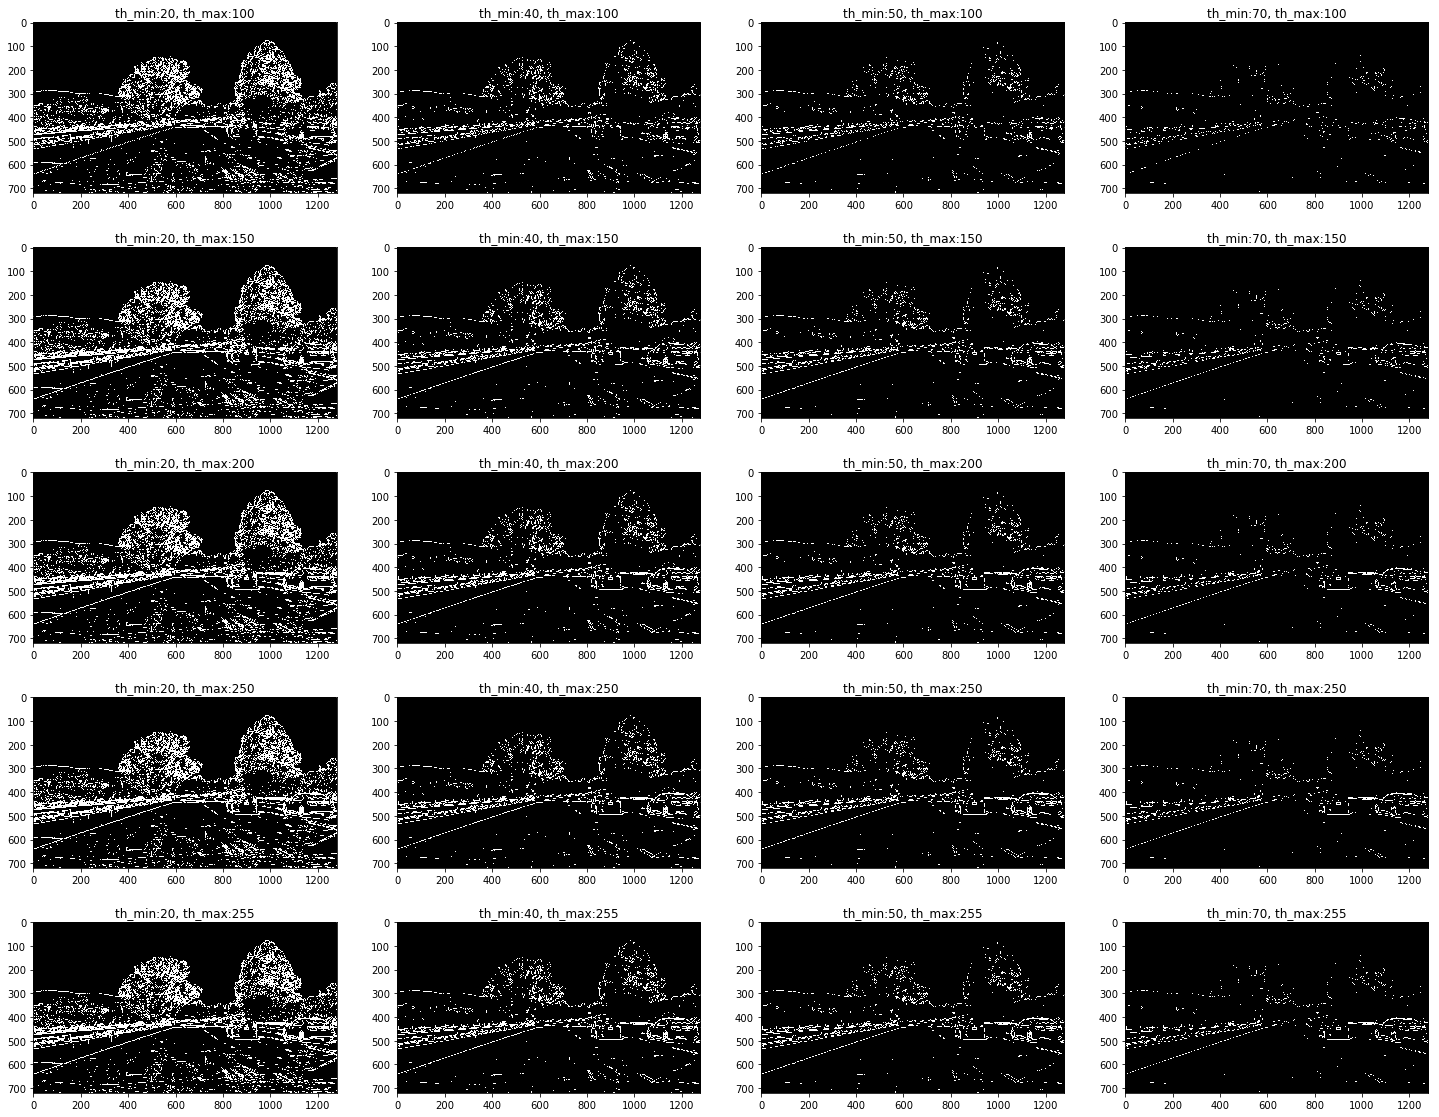

In [10]:
#  visualize result of get_magnitude_threshold_binary_image using some parameter
max_ths = [100, 150, 200, 250, 255]
min_ths = [20, 40, 50, 70]

i = 0
plt.figure(figsize=(25,20))
for max_th  in max_ths:
    for min_th in min_ths:
        plt.subplot(5, 4, i+1)
        train_image = get_magnitude_threshold_binary_image(image, sobel_kernel=3, thresh=(min_th, max_th))
        plt.imshow(train_image, cmap='gray')
        title = "th_min:{}, th_max:{}".format(min_th, max_th)
        plt.title(title)
        i += 1

#plt.savefig("magnitude_some_params_k3.png")

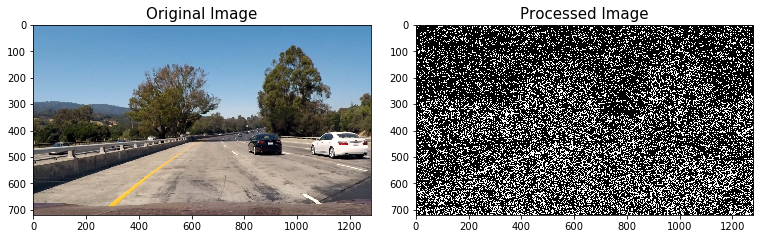

In [11]:
rad = 47*3.14/180
mad = 0.5
processed = get_dicrection_threshold_binary_image(image, sobel_kernel=3, thresh=(rad, rad+mad))
show_processed_images(image, processed)
#plt.savefig('k3_th47_m05_2.png')

## Apply a perspective transform to rectify binary image 

In [12]:
image = mpimg.imread('test_images/test1.jpg')

#left_margin = 250
#right_margin = 80
#vertices = np.array([[(left_margin, imshape[0]),(570, 420), (710, 420), (imshape[1] - right_margin, imshape[0])]], dtype=np.int32)

#target = np.float32([[(left_margin, imshape[0]),(570, 420), (710, 420), (imshape[1] - right_margin, imshape[0])]])

def get_warped_area_image(image):
    imshape = image.shape

    margin = 200
    vertices = np.array([[(margin, imshape[0]),(600, 450), (680, 450), (imshape[1]-margin, imshape[0])]], dtype=np.int32)

    plotted_image = cv2.polylines(image.copy(), vertices, 1, 255, thickness=3)
    #plt.imshow(plotted_image)
    return plotted_image

tmp = get_warped_area_image(image)

In [13]:
processed.shape

(720, 1280)

In [14]:
image_list = glob.glob('test_images/*.jpg')

for fname in image_list:
    image = mpimg.imread(fname)
    imshape = image.shape
    get_warped_area_image(image)
    output_name = 'result_' + fname.split('/')[-1]
    #plt.savefig(output_name)

In [15]:
def get_perspective_transformed_image(image):
    imshape = image.shape
    margin = 200
    dst_margin = 350
    
    target = np.float32([[(margin, imshape[0]),(600, 450), (680, 450), (imshape[1]-margin, imshape[0])]])
    destination = np.float32([[dst_margin, imshape[0]], [dst_margin, 0], [imshape[1] - dst_margin, 0], [imshape[1] - 300, imshape[0]]])
    M = cv2.getPerspectiveTransform(target, destination)
    return  cv2.warpPerspective(image, M, (imshape[1],  imshape[0]))


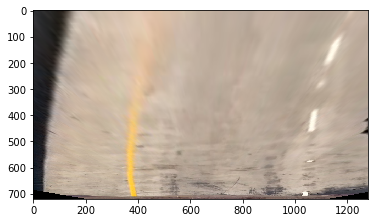

In [16]:
# warp
image = mpimg.imread('test_images/test1.jpg')
imshape = image.shape

margin = 200
dst_margin = 350
target = np.float32([[(margin, imshape[0]),(600, 450), (680, 450), (imshape[1]-margin, imshape[0])]])
#target = np.float32([[(margin, imshape[0]),(570, 420), (710, 420), (imshape[1]-margin, imshape[0])]])

destination = np.float32([[dst_margin, imshape[0]], [dst_margin, 0], [imshape[1] - dst_margin, 0], [imshape[1] - 300, imshape[0]]])

#destination = np.float32([[dst_margin, imshape[0] - dst_margin], [dst_margin, dst_margin], 
                         #[imshape[1] - dst_margin, dst_margin], [imshape[1] - dst_margin, imshape[0] - dst_margin]])

M = cv2.getPerspectiveTransform(target, destination)
w, h, c = image.shape
warped = cv2.warpPerspective(image, M, (h, w))
plt.imshow(warped)

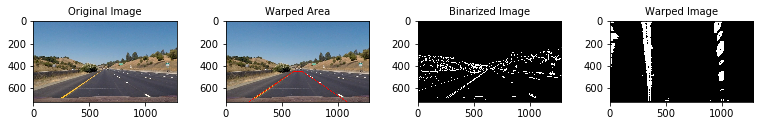

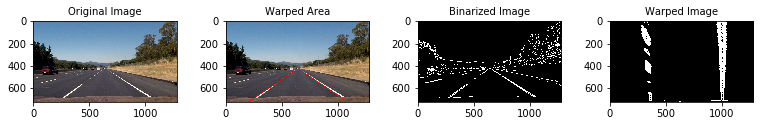

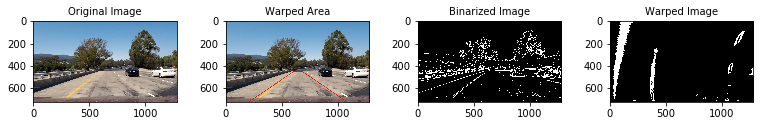

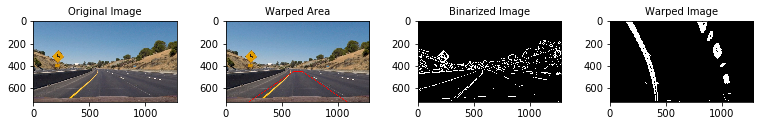

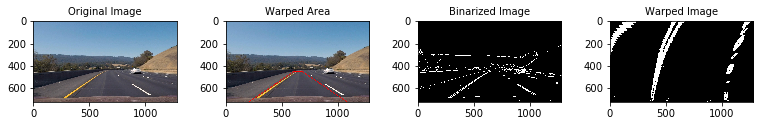

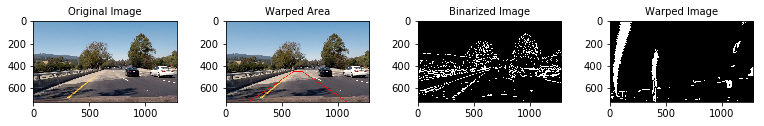

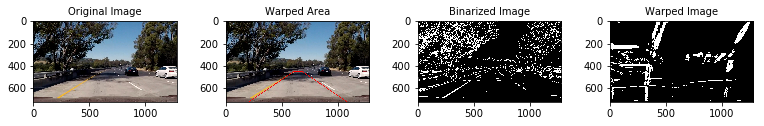

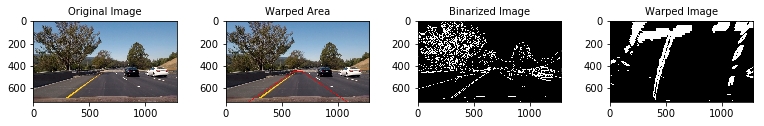

In [17]:
# visualizing preprocessed images
# Binalize -> Perspective transform

image_list = glob.glob('test_images/*.jpg')

for fname in image_list:
    image = mpimg.imread(fname)
    plotted = get_warped_area_image(image)
    processed = get_binary_image(image)
    warped = get_perspective_transformed_image(processed)

    #warped = get_perspective_transformed_image(image)
    #processed = get_binary_image(image)

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 6))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(plotted)
    ax2.set_title('Warped Area', fontsize=10)
    ax3.imshow(processed, cmap='gray')
    ax3.set_title('Binarized Image', fontsize=10)
    ax4.imshow(warped, cmap='gray')
    ax4.set_title('Warped Image', fontsize=10)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    output_name = 'pre2_' + fname.split('/')[-1]
    #plt.savefig(output_name, bbox_inches="tight")

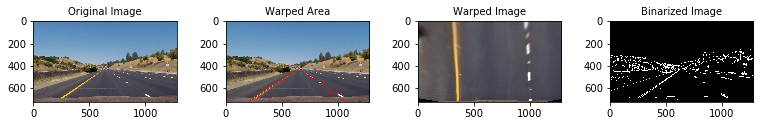

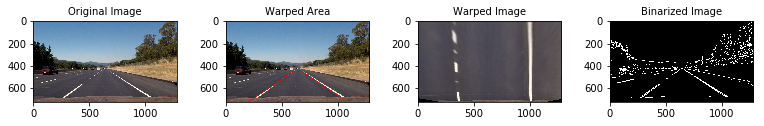

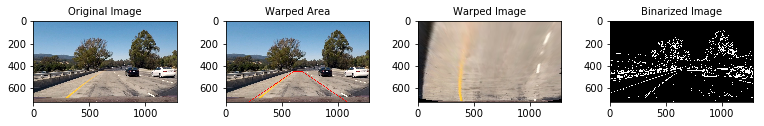

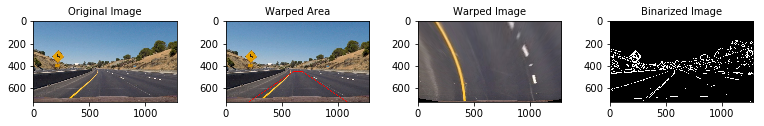

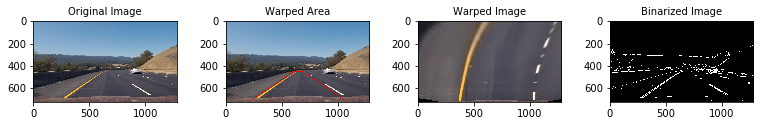

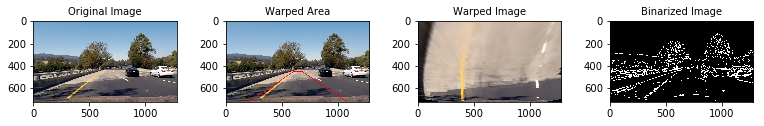

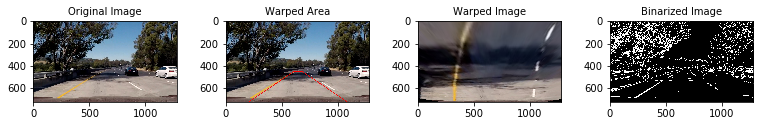

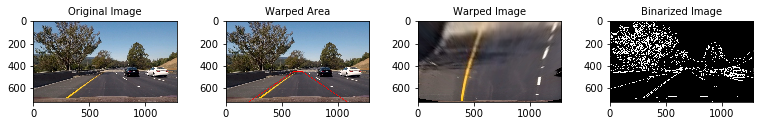

In [18]:
# visualizing preprocessed images,
# Perspective transform -> Binalize
image_list = glob.glob('test_images/*.jpg')

for fname in image_list:
    image = mpimg.imread(fname)
    plotted = get_warped_area_image(image)
    warped = get_perspective_transformed_image(image)
    processed = get_binary_image(image)

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 6))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=10)
    ax2.imshow(plotted)
    ax2.set_title('Warped Area', fontsize=10)
    ax3.imshow(warped)
    ax3.set_title('Warped Image', fontsize=10)
    ax4.imshow(processed, cmap='gray')
    ax4.set_title('Binarized Image', fontsize=10)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    output_name = 'pre_' + fname.split('/')[-1]
    #plt.savefig(output_name, bbox_inches="tight")